## <b><i>Modelo Estatístico para previsão de </b>'Gorjetas'</i>
<i>Registros obtidos de um restaurante, provavelmente no ano de 1990</i><br><br>
<b>Este conjunto de dados contém as seguintes informações:</b><br><br><i>
<b>total_bill:</b> valor total da conta.<br>
<b>tip:</b> valor da gorjeta.<br>
<b>sex:</b> sexo da pessoa que pagou a conta.<br>
<b>smoker:</b> indica se a pessoa que pagou a conta é fumante.<br>
<b>day:</b> dia da semana<br>
<b>time:</b> horário da refeição: almoço (lunch) ou jantar (dinner).<br>
**size:** indica o número de pessoas que estavam na mesa.<br>

Importação das bibliotécas

In [93]:
!pip install mlxtend -q
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import shapiro, pearsonr, spearmanr, kendalltau
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_breuschpagan

Configurações para os gráficos

In [94]:
plot_config= {
        "axes.facecolor": "#383838",    # Cor de fundo dos gráficos
        "figure.facecolor": "#383838",  # Cor de fundo da figura
        "text.color": "white",          # Cor do texto
        "axes.labelcolor": "white",     # Cor dos rótulos dos eixos
        "xtick.color": "white",         # Cor dos ticks do eixo x
        "ytick.color": "white",         # Cor dos ticks do eixo y
        "axes.edgecolor": "white",      # Cor das bordas dos gráficos
        "axes.spines.top": False,       # Ativar ou remover borda superior
        "axes.spines.right": False,     # Ativar ou remover borda direita
        "axes.grid": False,             # Ativar ou remover grade
        "grid.color": "#686868",        # Cor da grade
        "grid.linestyle": "--",         # Estilo da grade
        "figure.figsize": (10, 5)       # Tamanho padrão da figura
}
sns.set_theme(rc= plot_config)

Carga dos dados e configuração para exibição numérica

In [95]:
df= sns.load_dataset("tips")
pd.options.display.float_format = '{:.2f}'.format

Criação da variável <b>waiter_percent</b> (percentual recebido como gorjeta pelo garçon)<br>
usando <b>tip</b> (gorjeta) sobre <b>total_bill</b> (valor da conta)<br>
e em seguida uma pré visualização dos dados


In [96]:
df["waiter_percent"] = round((df["tip"] / df["total_bill"])* 100, 2)

print(f"A amostra contém {df.shape[0]} registros e {df.shape[1]} variáveis\n")
df.head(3)

A amostra contém 244 registros e 8 variáveis



,total_bill,tip,sex,smoker,day,time,size,waiter_percent
0,16.99,1.01,Female,No,Sun,Dinner,2,5.94
1,10.34,1.66,Male,No,Sun,Dinner,3,16.05
2,21.01,3.50,Male,No,Sun,Dinner,3,16.66


Quantidade de dados nulos para cada variável

In [97]:
df.isna().sum()

,0
total_bill,0
tip,0
sex,0
smoker,0
day,0
time,0
size,0
waiter_percent,0


Tipo dos dados

In [98]:
df.dtypes

,0
total_bill,float64
tip,float64
sex,category
smoker,category
day,category
time,category
size,int64
waiter_percent,float64


Analise descritiva das medidas de tendencia central

In [99]:
numericas = df.select_dtypes(include='number')
numericas.describe()

,total_bill,tip,size,waiter_percent
count,244.00,244.00,244.00,244.00
mean,19.79,3.00,2.57,16.08
std,8.90,1.38,0.95,6.11
min,3.07,1.00,1.00,3.56
25%,13.35,2.00,2.00,12.91
50%,17.80,2.90,2.00,15.47
75%,24.13,3.56,3.00,19.15
max,50.81,10.00,6.00,71.03


Visualização para análise de outliers

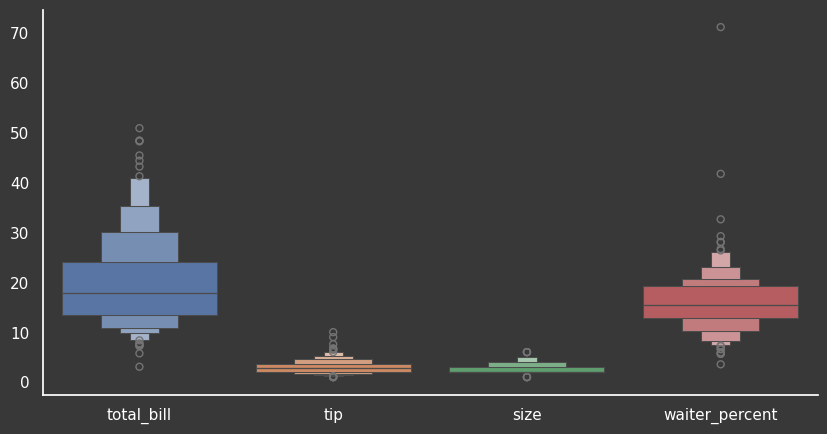

In [100]:
sns.boxenplot(numericas);

Verificação de dados únicos por variável categórica para análise de dados duplicados

In [101]:
categoricas = df.select_dtypes(include="category")
for i in categoricas.columns:
  print(f"Dados únicos da variável '{i}':\n{categoricas[i].unique()}\n")

Dados únicos da variável 'sex':
['Female', 'Male']
Categories (2, object): ['Male', 'Female']

Dados únicos da variável 'smoker':
['No', 'Yes']
Categories (2, object): ['Yes', 'No']

Dados únicos da variável 'day':
['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']

Dados únicos da variável 'time':
['Dinner', 'Lunch']
Categories (2, object): ['Lunch', 'Dinner']



### Transformação das Variáveis Categóricas
LabelEncoder

In [102]:
le = LabelEncoder()
for i in ["sex", "smoker", "time"]:
  df[i] = le.fit_transform(df[i])
df.head()

,total_bill,tip,sex,smoker,day,time,size,waiter_percent
0,16.99,1.01,0,0,Sun,0,2,5.94
1,10.34,1.66,1,0,Sun,0,3,16.05
2,21.01,3.50,1,0,Sun,0,3,16.66
3,23.68,3.31,1,0,Sun,0,2,13.98
4,24.59,3.61,0,0,Sun,0,4,14.68


One-Hot Encoding

In [103]:
df = pd.get_dummies(data=df, columns=["day"], dtype=int)
df.head(3)

,total_bill,tip,sex,smoker,time,size,waiter_percent,day_Thur,day_Fri,day_Sat,day_Sun
0,16.99,1.01,0,0,0,2,5.94,0,0,0,1
1,10.34,1.66,1,0,0,3,16.05,0,0,0,1
2,21.01,3.50,1,0,0,3,16.66,0,0,0,1


Teste de normalidade das variáveis.<br>
Um valor de p <= 0.05 rejeitamos a hipótese nula,<br>
ou seja, os dados não possuem distribuição normal.

In [104]:
print("Teste de Normalidade (Shapiro-Wilk):\n")
for col in numericas.columns:
  stat, p = shapiro(numericas[col])
  print(f"{col}: stat= {stat:.4f}, p= {p:.4f}")

Teste de Normalidade (Shapiro-Wilk):

total_bill: stat= 0.9197, p= 0.0000
tip: stat= 0.8978, p= 0.0000
size: stat= 0.7120, p= 0.0000
waiter_percent: stat= 0.7994, p= 0.0000


### Correlação de Pearson
O **Coeficiente de Correlação de Pearson** mede a **força** e a **direção** da relação linear entre duas variáveis quantitativas. Ele assume que as variáveis têm uma distribuição normal.

- **Quando usar**: Pearson é utilizado quando as variáveis têm uma relação linear e ambas seguem uma **distribuição normal**.

Onde $ r $ varia entre -1 e 1:
  - $ r = 1 $: Correlação positiva perfeita
  - $ r = -1 $: Correlação negativa perfeita
  - $ r = 0 $: Sem correlação linear

In [105]:
corr_pearson = df.corr(method="pearson")
corr_pearson

,total_bill,tip,sex,smoker,time,size,waiter_percent,day_Thur,day_Fri,day_Sat,day_Sun
total_bill,1.00,0.68,0.14,0.09,-0.18,0.60,-0.34,-0.14,-0.09,0.05,0.12
tip,0.68,1.00,0.09,0.01,-0.12,0.49,0.34,-0.10,-0.06,-0.00,0.13
sex,0.14,0.09,1.00,0.00,-0.21,0.09,-0.07,-0.19,-0.07,0.05,0.17
smoker,0.09,0.01,0.00,1.00,-0.05,-0.13,0.03,-0.13,0.24,0.16,-0.18
time,-0.18,-0.12,-0.21,-0.05,1.00,-0.10,0.03,0.92,0.06,-0.46,-0.42
size,0.60,0.49,0.09,-0.13,-0.10,1.00,-0.14,-0.07,-0.14,-0.04,0.19
waiter_percent,-0.34,0.34,-0.07,0.03,0.03,-0.14,1.00,0.00,0.04,-0.09,0.07
day_Thur,-0.14,-0.10,-0.19,-0.13,0.92,-0.07,0.00,1.00,-0.17,-0.43,-0.39
day_Fri,-0.09,-0.06,-0.07,0.24,0.06,-0.14,0.04,-0.17,1.00,-0.22,-0.20
day_Sat,0.05,-0.00,0.05,0.16,-0.46,-0.04,-0.09,-0.43,-0.22,1.00,-0.50


### Correlação de Spearman
O **Coeficiente de Spearman** mede a relação **monotônica** entre duas variáveis, o que significa que, à medida que uma variável aumenta, a outra também aumenta ou diminui, mas não necessariamente de forma linear.

- **Quando usar**: Use Spearman quando os dados não forem normalmente distribuídos ou se a relação entre as variáveis for **monotônica** (não linear).
- Baseia-se no ranking das variáveis.

In [106]:
corr_spearman = df.corr(method='spearman')
corr_spearman

,total_bill,tip,sex,smoker,time,size,waiter_percent,day_Thur,day_Fri,day_Sat,day_Sun
total_bill,1.00,0.68,0.15,0.06,-0.21,0.60,-0.32,-0.15,-0.10,0.05,0.15
tip,0.68,1.00,0.06,0.02,-0.14,0.47,0.40,-0.11,-0.04,-0.05,0.18
sex,0.15,0.06,1.00,0.00,-0.21,0.10,-0.10,-0.19,-0.07,0.05,0.17
smoker,0.06,0.02,0.00,1.00,-0.05,-0.13,-0.04,-0.13,0.24,0.16,-0.18
time,-0.21,-0.14,-0.21,-0.05,1.00,-0.16,0.08,0.92,0.06,-0.46,-0.42
size,0.60,0.47,0.10,-0.13,-0.16,1.00,-0.15,-0.14,-0.15,0.00,0.21
waiter_percent,-0.32,0.40,-0.10,-0.04,0.08,-0.15,1.00,0.04,0.05,-0.08,0.01
day_Thur,-0.15,-0.11,-0.19,-0.13,0.92,-0.14,0.04,1.00,-0.17,-0.43,-0.39
day_Fri,-0.10,-0.04,-0.07,0.24,0.06,-0.15,0.05,-0.17,1.00,-0.22,-0.20
day_Sat,0.05,-0.05,0.05,0.16,-0.46,0.00,-0.08,-0.43,-0.22,1.00,-0.50


### Correlação de Kendall
O **Coeficiente de Kendall** é outra medida não paramétrica que mede a associação entre duas variáveis. Ele leva em consideração a concordância entre pares de observações.

- **Quando usar**: Utilize Kendall quando o número de dados é pequeno, ou quando há muitos empates nos dados.
- Baseia-se na concordância e discordância de pares ordenados.

In [107]:
corr_kendall = df.corr(method='kendall')
corr_kendall

,total_bill,tip,sex,smoker,time,size,waiter_percent,day_Thur,day_Fri,day_Sat,day_Sun
total_bill,1.00,0.52,0.12,0.05,-0.17,0.48,-0.22,-0.12,-0.08,0.04,0.12
tip,0.52,1.00,0.05,0.01,-0.12,0.38,0.28,-0.09,-0.03,-0.04,0.15
sex,0.12,0.05,1.00,0.00,-0.21,0.09,-0.08,-0.19,-0.07,0.05,0.17
smoker,0.05,0.01,0.00,1.00,-0.05,-0.12,-0.03,-0.13,0.24,0.16,-0.18
time,-0.17,-0.12,-0.21,-0.05,1.00,-0.16,0.06,0.92,0.06,-0.46,-0.42
size,0.48,0.38,0.09,-0.12,-0.16,1.00,-0.12,-0.13,-0.15,0.00,0.20
waiter_percent,-0.22,0.28,-0.08,-0.03,0.06,-0.12,1.00,0.03,0.04,-0.06,0.01
day_Thur,-0.12,-0.09,-0.19,-0.13,0.92,-0.13,0.03,1.00,-0.17,-0.43,-0.39
day_Fri,-0.08,-0.03,-0.07,0.24,0.06,-0.15,0.04,-0.17,1.00,-0.22,-0.20
day_Sat,0.04,-0.04,0.05,0.16,-0.46,0.00,-0.06,-0.43,-0.22,1.00,-0.50


### Teste de Hipótese para Correlação entre total_bill e tip

- H0: rho = 0 (sem correlação)
- H1: rho ≠ 0

In [108]:
print("\nTeste de Hipótese - Correlação entre total_bill e tip")

r, p_valor = pearsonr(df["total_bill"], df["tip"])
print(f"Pearson r = {r:.4f}, p = {p_valor:.4f}")

r, p_valor = spearmanr(df["total_bill"], df["tip"])
print(f"Spearman r = {r:.4f}, p = {p_valor:.4f}")

r, p_valor = kendalltau(df["total_bill"], df["tip"])
print(f"Kendall tau = {r:.4f}, p = {p_valor:.4f}")

print("\nUm p-valor <= 0,05 indica uma Correlação significativa")


Teste de Hipótese - Correlação entre total_bill e tip
Pearson r = 0.6757, p = 0.0000
Spearman r = 0.6790, p = 0.0000
Kendall tau = 0.5172, p = 0.0000

Um p-valor <= 0,05 indica uma Correlação significativa


Visualização para Correlação entre 'total_bill' e 'tip'

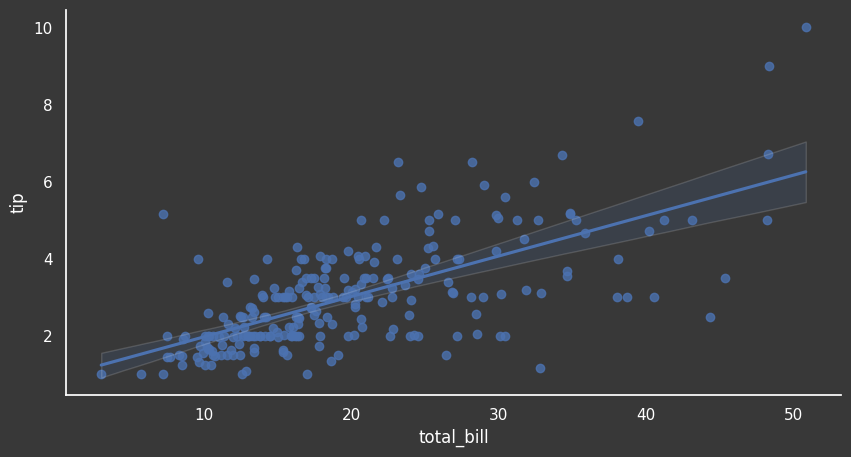

In [109]:
sns.regplot(data= df, x= "total_bill", y= "tip");

### Ausência de Multicolinearidade
Correlação das variáveis independentes

In [110]:
independentes = df[["total_bill", "size"]]
independentes.corr()

,total_bill,size
total_bill,1.00,0.60
size,0.60,1.00


## Escalonamento
###Padronização dos Dados

Padronização é o processo de centralizar as variáveis em torno da média e escalá-las para ter desvio padrão 1.

In [111]:
scaler = StandardScaler()
padronizadas = scaler.fit_transform(df)
padronizadas = pd.DataFrame(padronizadas, columns=df.columns)
padronizadas.head(3)

,total_bill,tip,sex,smoker,time,size,waiter_percent,day_Thur,day_Fri,day_Sat,day_Sun
0,-0.31,-1.44,-1.34,-0.78,-0.62,-0.60,-1.66,-0.58,-0.29,-0.74,1.49
1,-1.06,-0.97,0.74,-0.78,-0.62,0.45,-0.00,-0.58,-0.29,-0.74,1.49
2,0.14,0.36,0.74,-0.78,-0.62,0.45,0.10,-0.58,-0.29,-0.74,1.49


### Normalização Min-Max
A normalização Min-Max escala as variáveis para um intervalo específico, geralmente [0, 1], útil para algoritmos sensíveis à escala dos dados

In [112]:
minmax = MinMaxScaler()
normalizadas = minmax.fit_transform(df)
normalizadas = pd.DataFrame(normalizadas, columns=df.columns)
normalizadas.head(3)

,total_bill,tip,sex,smoker,time,size,waiter_percent,day_Thur,day_Fri,day_Sat,day_Sun
0,0.29,0.00,0.00,0.00,0.00,0.20,0.04,0.00,0.00,0.00,1.00
1,0.15,0.07,1.00,0.00,0.00,0.40,0.19,0.00,0.00,0.00,1.00
2,0.38,0.28,1.00,0.00,0.00,0.40,0.19,0.00,0.00,0.00,1.00


Divisão da base - Treino e Teste

In [113]:
X = padronizadas[["total_bill", "sex", "smoker", "time", "size", "day_Thur",
                  "day_Fri", "day_Sat", "day_Sun"]]
y = padronizadas["tip"]

# Separa os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

## Seleção de Variáveis
### Stepwise com AIC
**Teoria:**
**Stepwise Selection** é uma técnica que combina forward e backward selection, usando métricas como AIC.
- AIC penaliza modelos complexos.
- Permite encontrar subconjuntos de variáveis com bom poder preditivo sem overfitting.

In [114]:
def calculate_aic(model, X, y):
    n = len(y)
    k = X.shape[1] + 1  # número de parâmetros, incluindo o intercepto
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    aic = n * np.log(mse) + 2 * k
    return aic

### Implementação Stepwise Forward + Backward
Iremos criar as seguintes variáveis:

- selected_features: Lista que armazenará as variáveis selecionadas durante o procedimento.
- stepwise_model: Modelo de regressão linear a ser ajustado.
- best_aic: Variável que armazenará o menor AIC encontrado.

Seleção de variáveis com Stepwise (avançando e removendo as variáveis com base no menor AIC)

In [115]:
def forward_backward_stepwise_selection(X, y):
    selected = []
    best_aic = float('inf')
    model = LinearRegression()

    while True:
        changed = False
        candidates = [col for col in X.columns if col not in selected]
        best_candidate, best_model = None, None

        for feat in candidates:
            model.fit(X[selected + [feat]], y)
            aic = calculate_aic(model, X[selected + [feat]], y)
            if aic < best_aic:
                best_aic, best_candidate = aic, feat
                changed = True

        if changed:
            selected.append(best_candidate)
        else:
            break

    return selected

# Retorna lista de variáveis selecionadas pelo critério de AIC
selected_stepwise = forward_backward_stepwise_selection(X_train, y_train)
print("Selecionadas pelo Stepwise:", selected_stepwise)

Selecionadas pelo Stepwise: ['total_bill', 'size']


**Treinando modelo com variáveis selecionadas**

Ajuste do modelo Linear com as variáveis escolhidas

In [116]:
model_stepwise = LinearRegression().fit(X_train[selected_stepwise], y_train)
y_pred_stepwise = model_stepwise.predict(X_test[selected_stepwise])

**Avaliação do modelo Stepwise**

Calcular as métricas de avaliação para o modelo Stepwise

In [117]:
n = len(y_test)
k = len(selected_stepwise)
mse = mean_squared_error(y_test, y_pred_stepwise)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results = [{
    'Modelo': 'Stepwise',
    'MAE': mean_absolute_error(y_test, y_pred_stepwise),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': model_stepwise.score(X_test[selected_stepwise], y_test)
}]

pd.DataFrame(results)

,Modelo,MAE,MSE,AIC,BIC,R²
0,Stepwise,0.48,0.34,-48.84,-45.05,0.48


### SFS (Sequential Feature Selector)

O **SFS (mlxtend)** realiza seleção de variáveis de forma sequencial:
- `forward=True`: começa com nenhuma variável e vai adicionando.
- `floating=True`: permite remoção/backward no meio do processo.
- Permite validação cruzada com métrica personalizada (ex: MSE).

In [118]:
sfs_model = SFS(LinearRegression(),
                k_features='best',
                forward=True,
                floating=True,  # Ativa stepwise (entra e remove variáveis)
                scoring='neg_mean_squared_error',
                cv=5)

sfs_model.fit(X_train, y_train)
print("Variáveis selecionadas pelo SFS:", list(sfs_model.k_feature_names_))

Variáveis selecionadas pelo SFS: ['total_bill', 'smoker', 'day_Fri']


**Avaliação do modelo SFS**

In [119]:
selected_sfs = list(sfs_model.k_feature_names_)
model_sfs = LinearRegression().fit(X_train[selected_sfs], y_train)
y_pred_sfs = model_sfs.predict(X_test[selected_sfs])

n = len(y_test)
k = len(selected_sfs)
mse = mean_squared_error(y_test, y_pred_sfs)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results.append({
    'Modelo': 'SFS (mlxtend)',
    'MAE': mean_absolute_error(y_test, y_pred_sfs),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': model_sfs.score(X_test[selected_sfs], y_test)
})

pd.DataFrame(results)

,Modelo,MAE,MSE,AIC,BIC,R²
0,Stepwise,0.48,0.34,-48.84,-45.05,0.48
1,SFS (mlxtend),0.46,0.33,-48.20,-42.52,0.50


### ***Lasso (L1 Regularization)***

O **Lasso** aplica uma penalização  L1 que força alguns coeficientes a serem zero:
- Elimina variáveis irrelevantes automaticamente.
- Útil quando há muitas variáveis correlacionadas.
- O parâmetro alpha controla a intensidade da penalização.

In [120]:
alphas = np.logspace(-4, 4, 100)
lasso_cv = GridSearchCV(Lasso(), {'alpha': alphas}, cv=5)
lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.best_params_['alpha']

# Modelo final com o melhor alpha encontrado
lasso_final = Lasso(alpha=best_alpha).fit(X_train, y_train)

# Coeficientes diferentes de zero indicam variáveis selecionadas
lasso_coef = lasso_final.coef_
selected_lasso = X.columns[lasso_coef != 0]
print("Selecionadas pelo Lasso:", list(selected_lasso))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e-01, tolerance: 1.834e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e-01, tolerance: 1.505e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.962e-01, tolerance: 1.710e

Selecionadas pelo Lasso: ['total_bill', 'size']


In [121]:
y_pred_lasso = lasso_final.predict(X_test)

n = len(y_test)
k = len(selected_lasso)
mse = mean_squared_error(y_test, y_pred_lasso)
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

results.append({
    'Modelo': 'Lasso',
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'MSE': mse,
    'AIC': aic,
    'BIC': bic,
    'R²': lasso_final.score(X_test, y_test)
})

### Comparando os modelos

In [122]:
results_df = pd.DataFrame(results)
print(results_df)

          Modelo  MAE  MSE    AIC    BIC   R²
0       Stepwise 0.48 0.34 -48.84 -45.05 0.48
1  SFS (mlxtend) 0.46 0.33 -48.20 -42.52 0.50
2          Lasso 0.47 0.32 -52.17 -48.39 0.52


### 📌 Conclusões Didáticas
- **Stepwise**: bom ponto de partida, mas pode gerar overfitting.
- **Lasso**: ótimo para regularização e eliminar colinearidade.
- **SFS**: flexível e robusto com validação cruzada, porém mais lento.

### Uso do OLS para os Modelos

In [123]:
# Definindo as variáveis dependentes
X_sfs = X[['total_bill', 'smoker', 'day_Fri']]
X_lasso = X[['total_bill', 'size']]
# Adicionando uma constante à variável independente
X_sfs = sm.add_constant(X_sfs)
X_lasso = sm.add_constant(X_lasso)
# Ajustando o modelo de regressão linear
modelo_sfs = sm.OLS(y, X_sfs).fit()
modelo_lasso = sm.OLS(y, X_lasso).fit()
# Sumário do modelo
modelo_sfs_summary = modelo_sfs.summary()
modelo_lasso_summary = modelo_lasso.summary()

# sm.OLS() é usado para ajustar o modelo de regressão linear ordinária.
# sm.add_constant() é necessário pois o OLS não adiciona automaticamente a constante (intercepto).

### Teste de Homocedasticidade (Breusch-Pagan):
Se o p-valor do teste menor que 0.05, indica a presença de heterocedasticidade e pode ser necessário ajustar o modelo ou usar métodos robustos para estimativa de variância.

In [124]:
# Calcula os resíduos do modelo
# Criação de uma lista de tuplas com os modelos e seus respectivos nomes
modelos = [
    ("modelo_sfs", modelo_sfs, X[['total_bill', 'smoker', 'day_Fri']]),
    ("modelo_lasso", modelo_lasso, X[['total_bill', 'size']])
]

for nome, modelo,dados in modelos:
    estatistica, p, f, fp = het_breuschpagan(modelo.resid, modelo.model.exog)
    print(f'Estatísticas de teste para {nome}: {format(estatistica)}')
    print(f'p-valor: {p}')
    print(f'f-valor: {fp}')
    print(f'f_p-valor: {f}')

Estatísticas de teste para modelo_sfs: 53.72826958765993
p-valor: 1.2822263450715499e-11
f-valor: 6.444075975247554e-13
f_p-valor: 22.590121809992382
Estatísticas de teste para modelo_lasso: 48.15200992135925
p-valor: 3.498838520920026e-11
f-valor: 3.131697116564497e-12
f_p-valor: 29.626636419367546


#### Teste de Normalidade dos Resíduos com Shapiro-Wilk
Se p-valor do shapiro é superior a 0.05,isso indica que os resíduos seguem aproximadamente uma distribuição normal.

In [125]:
for nome, modelo,dados in modelos:
    estatistica_shapiro,p_shapiro = stats.shapiro(modelo.resid)
    print(f'Estatísticas de teste {nome}: {format(estatistica_shapiro)}')
    print('p-valor: {}'.format(p_shapiro))

Estatísticas de teste modelo_sfs: 0.964433393708254
p-valor: 9.247399460042297e-06
Estatísticas de teste modelo_lasso: 0.9666215690894155
p-valor: 1.7765393925723086e-05


### Análise dos Modelos

In [126]:
for nome, modelo, dados in modelos:
    print(str(modelo.summary()))

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     68.04
Date:                Wed, 24 Sep 2025   Prob (F-statistic):           7.10e-32
Time:                        14:28:00   Log-Likelihood:                -271.13
No. Observations:                 244   AIC:                             550.3
Df Residuals:                     240   BIC:                             564.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.533e-16      0.047   5.34e-15      1.0

No primeiro modelo as variáveis <b>smoker</b> e <b>day_Fri</b> não tiveram um valor $P$ significativo.<br>
Sugerindo que podem ser removidas.<br>
O segundo modelo explicou $46$% da variabilidade dos nossos dados usando o R ao quadrado Ajustado (por ser regressão multipla).<br>

#### Teste T:
O Teste T avalia a significância estatística de cada coeficiente no modelo. Um p-valor baixo (< 0.05) indica que o coeficiente é significativo.

#### Teste F:
O Teste F avalia a significância global do modelo. Um p-valor baixo (< 0.05) sugere que o modelo, como um todo, é significativo.

#### R² Ajustado:
O R² Ajustado reflete a porcentagem da variabilidade da variável dependente explicada pelo modelo, ajustada pelo número de preditores. Valores mais altos indicam um melhor ajuste.